# TLOB (Time-weighted Limit Order Book) Fiyat Tahmin Projesi

Bu notebook, TLOB kütüphanesi kullanarak limit order book verilerinden fiyat tahmini yapan kapsamlı bir analiz projesidir.

## Proje Özeti
- **Amaç**: Limit Order Book verilerinden gelecek fiyat hareketlerini tahmin etmek
- **Model**: TLOB (Time-weighted Limit Order Book) - Transformer tabanlı model
- **Veri**: AKBNK hisse senedi LOB verileri
- **Tahmin Türü**: Sınıflandırma (Yükseliş/Sabit/Düşüş)

## İçerik
1. [Gerekli Kütüphanelerin Yüklenmesi](#1-gerekli-kütüphanelerin-yüklenmesi)
2. [Konfigürasyon Yükleme](#2-konfigürasyon-yükleme)
3. [Veri Yükleme ve Ön İşleme](#3-veri-yükleme-ve-ön-işleme)
4. [TLOB Model Entegrasyonu](#4-tlob-model-entegrasyonu)
5. [Model Eğitimi](#5-model-eğitimi)
6. [Model Değerlendirmesi](#6-model-değerlendirmesi)
7. [Tahminler ve Görselleştirme](#7-tahminler-ve-görselleştirme)
8. [Sonuçlar ve Analiz](#8-sonuçlar-ve-analiz)

## ⚠️ Önemli Not
Bu notebook'u hücreleri sırayla çalıştırın. Her hücre önceki hücrelerin tamamlanmasını bekler.

## 1. Gerekli Kütüphanelerin Yüklenmesi

In [1]:
# Temel kütüphaneler
import os
import sys
import yaml
import warnings
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import json
from datetime import datetime

# Görselleştirme kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Proje kök dizinini bul ve Python path'ine ekle
# Notebook'un bulunduğu dizinden bir üst dizine çık (proje kökü)
project_root = os.path.dirname(os.path.abspath('.'))
# project_root = os.path.dirname(notebook_dir)  # notebooks/ dizininden bir üst
sys.path.append(project_root)

# Uyarıları kapat
warnings.filterwarnings('ignore')

# Matplotlib ayarları
plt.style.use('seaborn-v0_8')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 10

print("✅ Kütüphaneler başarıyla yüklendi!")
print(f"📁 Proje kök dizini: {project_root}")

✅ Kütüphaneler başarıyla yüklendi!
📁 Proje kök dizini: /Users/tolgacoskun-mac/Source/tlob-example


## 2. Konfigürasyon Yükleme

In [2]:
def load_config():
    """Konfigürasyon dosyasını yükle"""
    # Proje kök dizinindeki config dosyasını kullan
    config_path = os.path.join(project_root, 'config', 'config.yaml')
    
    if not os.path.exists(config_path):
        # Alternatif olarak mevcut dizinde ara
        alt_config_path = 'config/config.yaml'
        if os.path.exists(alt_config_path):
            config_path = alt_config_path
        else:
            raise FileNotFoundError(f"Konfigürasyon dosyası bulunamadı: {config_path}")
    
    print(f"📂 Konfigürasyon dosyası yükleniyor: {config_path}")
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Konfigürasyonu yükle
config = load_config()
print("📋 Konfigürasyon yüklendi:")
print(f"   Model tipi: {config['model']['type']}")
print(f"   Hidden dim: {config['model']['hidden_dim']}")
print(f"   Sequence size: {config['model']['seq_size']}")
print(f"   Learning rate: {config['training']['learning_rate']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Epochs: {config['training']['epochs']}")

# Gerekli dizinleri oluştur
models_dir = os.path.join(project_root, 'models')
results_dir = os.path.join(project_root, 'results')
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
print("✅ Gerekli dizinler oluşturuldu")

📂 Konfigürasyon dosyası yükleniyor: /Users/tolgacoskun-mac/Source/tlob-example/config/config.yaml
📋 Konfigürasyon yüklendi:
   Model tipi: TLOB
   Hidden dim: 64
   Sequence size: 64
   Learning rate: 0.0001
   Batch size: 512
   Epochs: 250
✅ Gerekli dizinler oluşturuldu


## 3. Veri Yükleme ve Ön İşleme

In [4]:
# Veri yükleme sınıfını import et
from src.data_loader import LOBDataLoader

# Veri dosyasını bul
data_source = config.get('data', {}).get('data_source', 'data/*.csv')

# Proje kök dizinindeki data klasörünü kontrol et
if data_source.endswith('*.csv'):
    # Önce proje kök dizininde ara
    data_files = glob.glob(os.path.join(project_root, 'data', '*.csv'))
    if not data_files:
        # Alternatif olarak mevcut dizinde ara
        data_files = glob.glob('data/*.csv')
    
    if not data_files:
        raise FileNotFoundError("❌ Data dizininde CSV dosyası bulunamadı!")
    data_path = data_files[0]
else:
    # Mutlak yol kullan
    if not os.path.isabs(data_source):
        data_path = os.path.join(project_root, data_source)
    else:
        data_path = data_source
    
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"❌ Veri dosyası bulunamadı: {data_path}")

print(f"📊 Veri yükleniyor: {data_path}")

# Veriyi yükle
data_loader = LOBDataLoader(data_path)
df = data_loader.load_data()

print(f"✅ Veri yüklendi: {len(df)} satır, {len(df.columns)} sütun")
print(f"📅 Tarih aralığı: {df['DateTime'].min()} - {df['DateTime'].max()}")
print(f"📈 Sembol: {data_loader.symbol}")

📊 Veri yükleniyor: /Users/tolgacoskun-mac/Source/tlob-example/data/2025-07-11-AKBNK-10.csv
Veri yükleniyor: /Users/tolgacoskun-mac/Source/tlob-example/data/2025-07-11-AKBNK-10.csv
Veri yüklendi. Satır sayısı: 28784
Sütunlar: ['DateTime', 'Symbol', 'Level', 'Depth Ratio', 'Last Price', 'Total Bid Volume', 'Total Ask Volume', 'Level 1 Bid Price', 'Level 1 Bid Volume', 'Level 1 Ask Price', 'Level 1 Ask Volume', 'Level 2 Bid Price', 'Level 2 Bid Volume', 'Level 2 Ask Price', 'Level 2 Ask Volume', 'Level 3 Bid Price', 'Level 3 Bid Volume', 'Level 3 Ask Price', 'Level 3 Ask Volume', 'Level 4 Bid Price', 'Level 4 Bid Volume', 'Level 4 Ask Price', 'Level 4 Ask Volume', 'Level 5 Bid Price', 'Level 5 Bid Volume', 'Level 5 Ask Price', 'Level 5 Ask Volume', 'Level 6 Bid Price', 'Level 6 Bid Volume', 'Level 6 Ask Price', 'Level 6 Ask Volume', 'Level 7 Bid Price', 'Level 7 Bid Volume', 'Level 7 Ask Price', 'Level 7 Ask Volume', 'Level 8 Bid Price', 'Level 8 Bid Volume', 'Level 8 Ask Price', 'Level 8

In [5]:
# Veri özeti
print("📊 Veri Özeti:")
print("=" * 50)
print(df.info())
print("\n📈 İlk 5 satır:")
print(df.head())
print("\n📉 Son 5 satır:")
print(df.tail())

📊 Veri Özeti:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28784 entries, 0 to 28783
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             28784 non-null  datetime64[ns]
 1   Symbol               28784 non-null  object        
 2   Level                28784 non-null  int64         
 3   Depth Ratio          28784 non-null  float64       
 4   Last Price           28784 non-null  float64       
 5   Total Bid Volume     28784 non-null  float64       
 6   Total Ask Volume     28784 non-null  float64       
 7   Level 1 Bid Price    28784 non-null  float64       
 8   Level 1 Bid Volume   28784 non-null  float64       
 9   Level 1 Ask Price    28784 non-null  float64       
 10  Level 1 Ask Volume   28784 non-null  float64       
 11  Level 2 Bid Price    28784 non-null  float64       
 12  Level 2 Bid Volume   28784 non-null  float64       
 13  Level 2 Ask Price

In [6]:
# Veri istatistikleri
print("📊 Veri İstatistikleri:")
print("=" * 50)

# Mid price hesapla
df['mid_price'] = (df['Level 1 Bid Price'] + df['Level 1 Ask Price']) / 2

# Fiyat istatistikleri
print(f"💰 Mid Price İstatistikleri:")
print(f"   Ortalama: {df['mid_price'].mean():.4f}")
print(f"   Standart Sapma: {df['mid_price'].std():.4f}")
print(f"   Minimum: {df['mid_price'].min():.4f}")
print(f"   Maksimum: {df['mid_price'].max():.4f}")
print(f"   Medyan: {df['mid_price'].median():.4f}")

# Eksik değerler
print(f"\n🔍 Eksik Değerler:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

📊 Veri İstatistikleri:
💰 Mid Price İstatistikleri:
   Ortalama: 70.1942
   Standart Sapma: 0.5954
   Minimum: 69.0250
   Maksimum: 71.5250
   Medyan: 70.3750

🔍 Eksik Değerler:
Series([], dtype: int64)


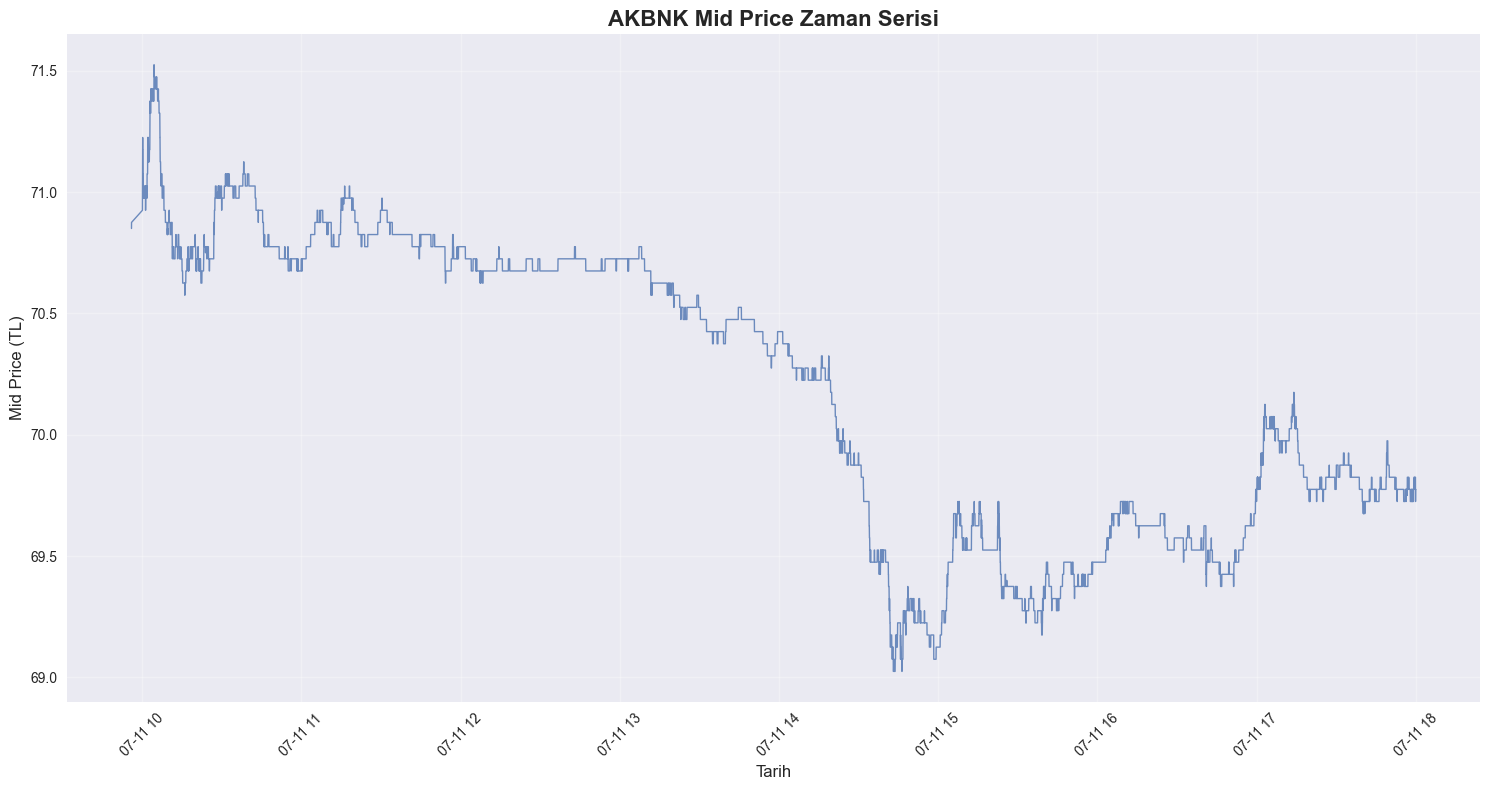

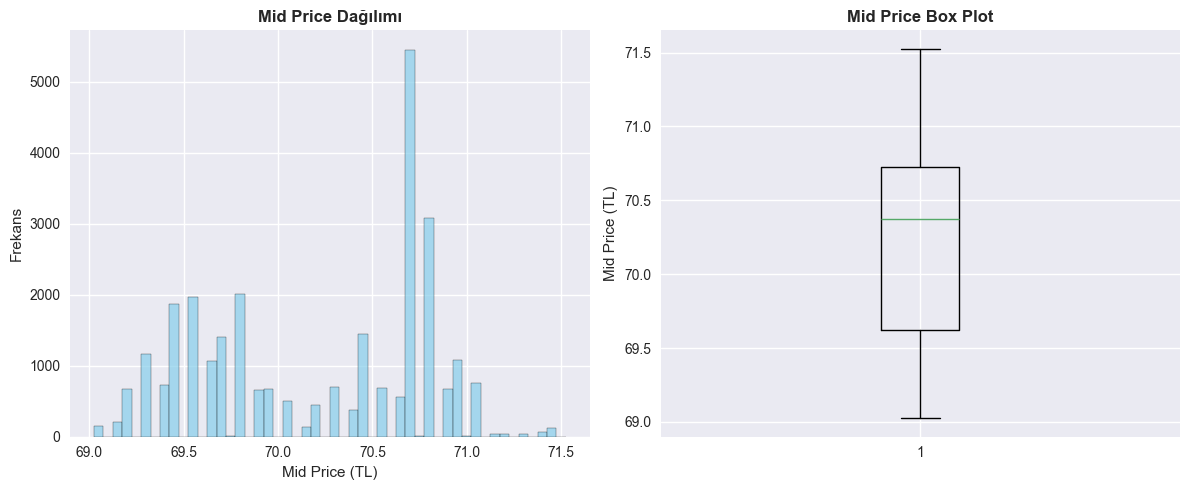

In [7]:
# Fiyat grafiği
plt.figure(figsize=(15, 8))
plt.plot(df['DateTime'], df['mid_price'], linewidth=1, alpha=0.8)
plt.title(f'{data_loader.symbol} Mid Price Zaman Serisi', fontsize=16, fontweight='bold')
plt.xlabel('Tarih', fontsize=12)
plt.ylabel('Mid Price (TL)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Fiyat dağılımı
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['mid_price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Mid Price Dağılımı', fontweight='bold')
plt.xlabel('Mid Price (TL)')
plt.ylabel('Frekans')

plt.subplot(1, 2, 2)
plt.boxplot(df['mid_price'])
plt.title('Mid Price Box Plot', fontweight='bold')
plt.ylabel('Mid Price (TL)')
plt.tight_layout()
plt.show()

## 4. TLOB Model Entegrasyonu

In [8]:
# TLOB entegrasyonunu import et
from src.tlob_integration import TLOBIntegration

# TLOB konfigürasyonu
tlob_config = {
    'hidden_dim': config['model']['hidden_dim'],
    'num_layers': config['model']['num_layers'],
    'seq_size': config['model']['seq_size'],
    'num_heads': config['model'].get('num_heads', 1),
    'is_sin_emb': config['model'].get('is_sin_emb', True),
    'lr': config['training']['learning_rate'],
    'batch_size': config['training']['batch_size'],
    'horizon': config['model']['horizon'],
    'forecast_days': config['model']['forecast_days'],
    'early_stopping_patience': config['training']['early_stopping_patience'],
    'min_delta': config['training'].get('min_delta', 0.001),
    'data': {
        'train_split': 0.72,
        'val_split': 0.18,
        'test_split': 0.10
    }
}

print("🤖 TLOB model entegrasyonu başlatılıyor...")
print(f"   Hidden dim: {tlob_config['hidden_dim']}")
print(f"   Num layers: {tlob_config['num_layers']}")
print(f"   Sequence size: {tlob_config['seq_size']}")
print(f"   Learning rate: {tlob_config['lr']}")
print(f"   Batch size: {tlob_config['batch_size']}")

# TLOB entegrasyonunu başlat
tlob_integration = TLOBIntegration(tlob_config)

🤖 TLOB model entegrasyonu başlatılıyor...
   Hidden dim: 64
   Num layers: 3
   Sequence size: 64
   Learning rate: 0.0001
   Batch size: 512


In [ ]:
# Veriyi TLOB için hazırla
print("🔄 Veri TLOB modeli için hazırlanıyor...")
num_features = tlob_integration.prepare_data(data_path)
print(f"✅ Veri hazırlandı: {num_features} özellik")

# Model oluştur
print("\n🏗️ Model oluşturuluyor...")
model = tlob_integration.create_model(num_features)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model oluşturuldu:")
print(f"   Toplam parametre: {total_params:,}")
print(f"   Eğitilebilir parametre: {trainable_params:,}")
print(f"   Model boyutu: {total_params * 4 / 1024 / 1024:.2f} MB")

🔄 Veri TLOB modeli için hazırlanıyor...
📊 Price Analysis:
   Bid Price range: 69.00 - 71.50
   Ask Price range: 69.05 - 71.55
   Mid Price range: 69.03 - 71.53
   Sample mid prices: [70.85, 70.875, 70.92500000000001, 70.92500000000001, 70.92500000000001]


## 5. Model Eğitimi

In [2]:
# Model eğitimi
print("🏋️ Model eğitimi başlıyor...")
print("=" * 60)

max_epochs = config['training']['epochs']
print(f"📊 Eğitim parametreleri:")
print(f"   Maksimum epoch: {max_epochs}")
print(f"   Learning rate: {config['training']['learning_rate']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Early stopping patience: {config['training']['early_stopping_patience']}")
print(f"   Min delta: {config['training'].get('min_delta', 0.001)}")

# Eğitimi başlat
training_history = tlob_integration.train_model(max_epochs=max_epochs)
print("\n✅ Eğitim tamamlandı!")

🏋️ Model eğitimi başlıyor...


NameError: name 'config' is not defined

In [ ]:
# Eğitim geçmişini görselleştir
if 'training_history' in locals() and training_history:
    print("📈 Eğitim geçmişi görselleştiriliyor...")
    
    # Eğitim ve validasyon loss'ları
    train_losses = [h['train_loss'] for h in training_history]
    val_losses = [h['val_loss'] for h in training_history]
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Eğitim Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validasyon Loss', linewidth=2)
    plt.title('Eğitim ve Validasyon Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Eğitim ve validasyon accuracy'leri
    train_accs = [h.get('train_acc', 0) for h in training_history]
    val_accs = [h.get('val_acc', 0) for h in training_history]
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b-', label='Eğitim Accuracy', linewidth=2)
    plt.plot(epochs, val_accs, 'r-', label='Validasyon Accuracy', linewidth=2)
    plt.title('Eğitim ve Validasyon Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Son epoch bilgileri
    print(f"\n📊 Son Epoch Bilgileri:")
    print(f"   Epoch: {len(training_history)}")
    print(f"   Son eğitim loss: {train_losses[-1]:.4f}")
    print(f"   Son validasyon loss: {val_losses[-1]:.4f}")
    print(f"   Son eğitim accuracy: {train_accs[-1]:.4f}")
    print(f"   Son validasyon accuracy: {val_accs[-1]:.4f}")
else:
    print("⚠️ Eğitim geçmişi bulunamadı. Önce model eğitimini tamamlayın.")

## 6. Model Değerlendirmesi

In [ ]:
# En iyi modeli yükle
print("📥 En iyi model yükleniyor...")
model_path = os.path.join(project_root, 'models', 'best_tlob_model.pth')
try:
    model.load_state_dict(torch.load(model_path))
    tlob_integration.model = model
    print("✅ En iyi model yüklendi")
except FileNotFoundError:
    print(f"⚠️ En iyi model dosyası bulunamadı: {model_path}")
    print("Önce model eğitimini tamamlayın.")
    raise

# Model performansını değerlendir
print("\n🧪 Model performansı değerlendiriliyor...")
test_metrics = tlob_integration.evaluate_model()

print("\n📊 Test Metrikleri:")
print("=" * 50)
for metric_name, metric_value in test_metrics.items():
    if isinstance(metric_value, float):
        print(f"   {metric_name}: {metric_value:.4f}")
    else:
        print(f"   {metric_name}: {metric_value}")

In [ ]:
# Test metriklerini kaydet
tlob_integration.save_test_metrics(test_metrics)
print("✅ Test metrikleri kaydedildi")

# Metrikleri görselleştir
print("\n📊 Metrik görselleştirmeleri oluşturuluyor...")

# Sınıf dağılımı
if 'class_distribution' in test_metrics:
    class_dist = test_metrics['class_distribution']
    classes = ['Düşüş', 'Sabit', 'Yükseliş']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, [class_dist.get(str(i), 0) for i in range(3)], 
                   color=['red', 'gray', 'green'], alpha=0.7)
    plt.title('Test Verisi Sınıf Dağılımı', fontsize=14, fontweight='bold')
    plt.xlabel('Sınıf')
    plt.ylabel('Örnek Sayısı')
    
    # Değerleri çubukların üzerine yaz
    for bar, value in zip(bars, [class_dist.get(str(i), 0) for i in range(3)]):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                str(value), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Confusion matrix
if 'confusion_matrix' in test_metrics:
    cm = test_metrics['confusion_matrix']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.ylabel('Gerçek Sınıf')
    plt.tight_layout()
    plt.show()

## 7. Tahminler ve Görselleştirme

In [ ]:
# Test verisi üzerinde tahminler yap
print("🔮 Tahminler yapılıyor...")

# Test verisi al
test_loader = tlob_integration.data_module.test_dataloader()
test_batch = next(iter(test_loader))
test_data = test_batch[0]  # İlk batch verisi
test_labels = test_batch[1]  # İlk batch etiketleri

# Tek tahmin
print("\n📊 Tek tahmin örneği:")
prediction, probabilities = tlob_integration.predict(test_data[0].numpy())
direction_map = {0: "Yükseliş", 1: "Sabit", 2: "Düşüş"}
print(f"   Tahmin: {direction_map[prediction]} (Sınıf {prediction})")
print(f"   Güven: {np.max(probabilities):.2%}")
print(f"   Tüm olasılıklar: {probabilities}")

In [ ]:
# N-günlük tahmin
forecast_days = config['model']['forecast_days']
print(f"\n📅 {forecast_days} günlük tahmin oluşturuluyor...")
forecast = tlob_integration.predict_days(test_data.numpy())

# Tahmin sonuçlarını göster
print(f"\n{forecast_days} Günlük Mid Price Tahmin Sonuçları:")
print("=" * 70)

for day_result in forecast:
    day = day_result['day']
    pred = day_result['prediction']
    conf = day_result['confidence']
    mid_price = day_result['mid_price'].item() if hasattr(day_result['mid_price'], 'item') else float(day_result['mid_price'])
    change_pct = day_result['price_change_pct'].item() if hasattr(day_result['price_change_pct'], 'item') else float(day_result['price_change_pct'])
    direction = direction_map[pred]
    
    print(f"  Gün {day:2d}: {direction:8s} | Mid Price: {mid_price:8.4f} | Değişim: {change_pct:+6.2f}% | Güven: {conf:6.2%}")

print("=" * 70)

In [ ]:
# Tahmin görselleştirmeleri
print("\n📊 Tahmin görselleştirmeleri oluşturuluyor...")

# Görselleştirme sınıfını import et
from src.visualization import LOBVisualizer
viz = LOBVisualizer()

# Eğitim geçmişi
print("📈 Eğitim geçmişi çiziliyor...")
viz.plot_training_history(tlob_integration)

# Fiyat evrimi
print("📊 Fiyat evrimi çiziliyor...")
viz.plot_price_evolution(data_loader)

# Tahmin grafiği
print("🔮 Tahmin grafiği çiziliyor...")
viz.plot_forecast(forecast)

print("✅ Tüm görselleştirmeler tamamlandı!")

## 8. Sonuçlar ve Analiz

In [ ]:
# Proje özeti
print("🎉 TLOB Fiyat Tahmin Projesi Tamamlandı!")
print("=" * 60)

print(f"📊 Proje Özeti:")
print(f"   Veri kaynağı: {data_path}")
print(f"   Toplam veri: {len(df):,} satır")
print(f"   Model tipi: {config['model']['type']}")
print(f"   Model parametreleri: {total_params:,}")
print(f"   Eğitim epoch'ları: {len(training_history) if 'training_history' in locals() else 'N/A'}")
print(f"   Test accuracy: {test_metrics.get('accuracy', 'N/A'):.4f}")
print(f"   Test precision: {test_metrics.get('precision', 'N/A'):.4f}")
print(f"   Test recall: {test_metrics.get('recall', 'N/A'):.4f}")
print(f"   Test f1_score: {test_metrics.get('f1_score', 'N/A'):.4f}")

print(f"\n📁 Kaydedilen Dosyalar:")
print(f"   Model: {os.path.join(project_root, 'models', 'best_tlob_model.pth')}")
print(f"   Test metrikleri: {os.path.join(project_root, 'results', 'test_metrics.json')}")
print(f"   Görselleştirmeler: {os.path.join(project_root, 'results')}")

print(f"\n🔮 Tahmin Özeti:")
up_count = sum(1 for f in forecast if f['prediction'] == 0)
stable_count = sum(1 for f in forecast if f['prediction'] == 1)
down_count = sum(1 for f in forecast if f['prediction'] == 2)
print(f"   Yükseliş tahmini: {up_count} gün")
print(f"   Sabit tahmini: {stable_count} gün")
print(f"   Düşüş tahmini: {down_count} gün")

print("\n✅ Analiz tamamlandı! Sonuçlar 'results/' dizininde kaydedildi.")

In [ ]:
# Sonuçları JSON olarak kaydet
final_results = {
    'project_info': {
        'name': 'TLOB Price Prediction Project',
        'date': datetime.now().isoformat(),
        'data_source': data_path,
        'total_data_points': len(df),
        'model_type': config['model']['type']
    },
    'model_config': config,
    'training_summary': {
        'total_epochs': len(training_history) if 'training_history' in locals() else 0,
        'final_train_loss': training_history[-1]['train_loss'] if 'training_history' in locals() and training_history else None,
        'final_val_loss': training_history[-1]['val_loss'] if 'training_history' in locals() and training_history else None,
        'model_parameters': total_params
    },
    'test_metrics': test_metrics,
    'forecast_summary': {
        'forecast_days': forecast_days,
        'predictions': [{
            'day': f['day'],
            'prediction': direction_map[f['prediction']],
            'confidence': float(f['confidence']),
            'mid_price': float(f['mid_price']),
            'price_change_pct': float(f['price_change_pct'])
        } for f in forecast]
    }
}

# JSON dosyasına kaydet
results_file = os.path.join(project_root, 'results', 'final_analysis_results.json')
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=2, ensure_ascii=False)

print(f"✅ Final analiz sonuçları kaydedildi: {results_file}")